# Tests: Fixed Equation Forms
This notebook tests SHARE fitting given fixed programs (equation forms). Do the shape functions fit properly? 

## 0. Setup

In [1]:
import numpy as np 
import pandas as pd 
import torch

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")

from gplearn.gplearn._program import _Program 
import survshares.lightning # SBL Patch

%load_ext autoreload
%autoreload 2

In [2]:
from gplearn.gplearn.model import ShapeNN
from gplearn.gplearn.fitness import mean_square_error
from gplearn.gplearn.functions import add2, sub2, mul2, div2, shape1
from sklearn.utils.validation import check_random_state


share_params = {
    "function_set": [add2, sub2, mul2, div2],
    "arities": {2: [add2, sub2, mul2, div2]},
    "init_depth": (2, 6),
    "init_method": "half and half",
    "n_features": 10,
    "const_range": (-1.0, 1.0),
    "metric": mean_square_error,
    "p_point_replace": 0.05,
    "parsimony_coefficient": 0.1,
    "optim_dict": {
        "alg": "adam",
        "lr": 1e-2,  # tuned automatically
        "max_n_epochs": 1000,
        "tol": 1e-3,
        "task": "regression",
        "device": "cpu",
        "batch_size": 1000,
        "shape_class": ShapeNN,
        "constructor_dict": {
            "n_hidden_layers": 5,
            "width": 10,
            "activation_name": "ELU",
        },
        "num_workers_dataloader": 0,
        "seed": 42,
        "checkpoint_folder": "results/checkpoints/test",
        "keep_models": False,
        "enable_progress_bar": False,
    },
    "random_state": check_random_state(415),
}

## 1. No Shape Functions

We first test a simple program with no shape functions as a sanity check.

In [3]:
from sklearn.utils._testing import assert_array_almost_equal


def test_program():
    """Check executing the program works"""

    # Test for a small program
    test_gp = [mul2, div2, 8, 1, sub2, 9, 0.5]
    X = np.reshape(share_params["random_state"].uniform(size=50), (5, 10))
    gp = _Program(program=test_gp, **share_params)

    result = gp.execute(torch.Tensor(X))
    expected = (X[:, 8] / X[:, 1]) * (X[:, 9] - 0.5)
    assert_array_almost_equal(result, expected)


test_program()

## 2. Univariate Regression 

We check the shapes learned by fitting these univariate equations:

1. $y=x^2$
2. $y=x^3$
3. $y=x+5$
4. $y=x$ (thus $s(x) = x)$
5. $y=sin(x)$
6. $y=cos(exp(tan(x)))$ 

In [4]:
%%capture
def test_shares_univariate():
    test_share = [shape1, 0]
    X_train, X_test = np.sort(np.random.rand(1000, 1), axis=0), np.sort(np.random.rand(1000, 1), axis=0)

    tests = {
        'y=x^2': lambda x: x ** 2,
        'y=x^3': lambda x: x ** 3,
        'y=x+5': lambda x: x + 5,
        'y=x': lambda x: x,
        'y=sin(x \pi)': lambda x: np.sin(x*np.pi),
        'y=cos(exp(tan(x)))': lambda x: np.cos(np.exp(np.tan(x))),
    }

    fig, axes = plt.subplots(2, 3, figsize=(10, 5))

    results = {}
    for ax, (name, func) in zip(axes.flatten(), tests.items()):
        y_train, y_test = func(X_train[:, 0]), func(X_test[:, 0])
        gp = _Program(program=test_share, **share_params)
        gp.raw_fitness(torch.Tensor(X_train), torch.Tensor(y_train), None)
        y_pred = gp.execute(torch.Tensor(X_test))
        results[name] = np.abs(y_pred - y_test).mean()

        ax.plot(X_test, y_pred, label='Predicted', color='blue')
        ax.plot(X_test, y_test, label='True', color='red')
        ax.set_title(f'${name}$ : $\pm {results[name]:.2f}$')


    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    return fig, results

fig_univariate, results_univariate = test_shares_univariate()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_ded01b80-425b-4a54-997d-cb188d6ee877.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_ded01b80-425b-4a54-997d-cb188d6ee877.ckpt
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_20390422-e359-4f68-be96-eab34297fbbf.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_20390422-e359-4f68-be96-eab34297fbbf.ckpt
G

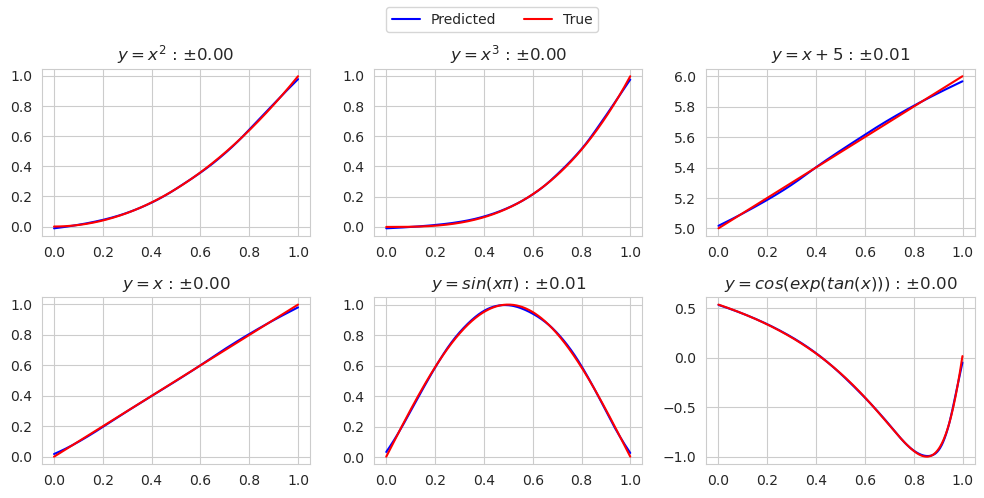

In [5]:
fig_univariate

## 3. Multivariate Regression

Next we check the following equations with more variables:

1. $y=x_1 + x_2$ (thus $s(x) = x$)
2. $y=x_1^2 + x_2/2$
3. $y=s(x_1) + s(x_2) + s(x_3)$ (risk study)

We observe that the learned shape functions are vertically translated from the ground truth - this is expected.

In [7]:
%%capture
def test_shares_bivariate():
    test_share = [add2, shape1, 0, shape1, 1]
    X_train, X_test = np.random.rand(1000, 2), np.random.rand(1000, 2)

    tests = {
        'y=x_1 + x_2': [
            lambda x: x, 
            lambda x: x 
        ],
        'y=x_1^2 + sin(x_2 \pi)': [
            lambda x: x ** 2, 
            lambda x: np.sin(x * np.pi)
        ],
    }

    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    results = {}

    for ax_row, (name, functions) in zip(axes, tests.items()):
        y_train = functions[0](X_train[:, 0]) + functions[1](X_train[:, 1])
        y_test = functions[0](X_test[:, 0]) + functions[1](X_test[:, 1])

        gp = _Program(program=test_share, **share_params)
        gp.raw_fitness(torch.Tensor(X_train), torch.Tensor(y_train), None)
        y_pred = gp.execute(torch.Tensor(X_test))

        for i, (ax, func, shape, x_true) in enumerate(zip(ax_row, functions, gp.model.shape_functions, X_test.T)):
            x_true = np.sort(X_test[:, i])
            s_true = func(x_true)
            shape.to(torch.device('cpu'))
            with torch.no_grad():
                s_pred = shape(torch.Tensor(x_true)).flatten()

            result = np.corrcoef(s_pred.numpy(), s_true)[0, 1]
            results[f'{name}_{i}'] = result
            ax.plot(x_true, s_pred, label='Shape', color='blue')
            ax.plot(x_true, s_true, label='Ground Truth', color='red')
            ax.set_title(f'${name}: s_{i+1}$ : $Corr={result:.2f}$')

    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    return fig, results

fig_bivariate, results_bivariate = test_shares_bivariate()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.008317637711026709
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_3c9cc922-648d-4925-93b2-e112b2e42e65.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_3c9cc922-648d-4925-93b2-e112b2e42e65.ckpt
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.008317637711026709
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_305638cc-f114-438d-a389-e3a902f17fbd.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_305638cc-f114-438d-a389-e3a902f17fbd.ckpt
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

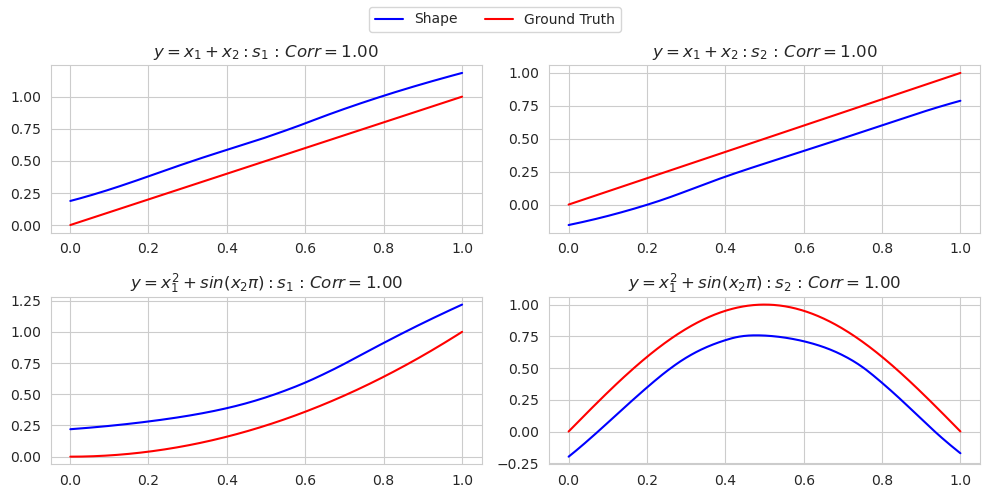

In [8]:
fig_bivariate

In [9]:
%%capture
from experiments.risk_scores_data import get_nodes_feature, get_age_feature, get_bmi_feature, generate_data
from sklearn.model_selection import train_test_split

def get_dataset():
    df = generate_data(1000, seed=42)
    X = df.drop(columns=['target']).values
    y = df['target'].values

    return train_test_split(X, y, test_size=0.2, random_state=42)

def test_shares_risk():
    test_share = [add2, add2, shape1, 0, shape1, 1, shape1, 2]
    X_train, X_test, y_train, y_test = get_dataset()

    features = {
        'nodes': (
            get_nodes_feature, 
            (0, 50, 1000)
        ),
        'age': (
            get_age_feature, 
            (45,70,1000)
        ),
        'bmi': (
            get_bmi_feature, 
            (17,45,1000)
        )
    }

    gp = _Program(program=test_share, **share_params)
    gp.raw_fitness(torch.Tensor(X_train), torch.Tensor(y_train), None)
    y_pred = gp.execute(torch.Tensor(X_test))
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    results = {}

    for i, (ax, shape, (name, (func, ranges))) in enumerate(zip(ax, gp.model.shape_functions, features.items())):
        x_true = np.linspace(*ranges)
        s_true = func()(x_true) 
        shape.to(torch.device('cpu'))
        with torch.no_grad():
            s_pred = shape(torch.Tensor(x_true)).flatten()

        result = np.corrcoef(s_pred.numpy(), s_true)[0, 1]
        results[f'{name}_{i}'] = result
        ax.plot(x_true, s_pred, label='Shape', color='blue')
        ax.plot(x_true, s_true, label='Ground Truth', color='red')
        ax.set_title(f'$s_{i}(${name}$)$ : Corr=${result:.2f}$')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig, results 

fig_risk, results_risk = test_shares_risk()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_66db8cd3-9316-463b-bff7-e7064ffb870e.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_66db8cd3-9316-463b-bff7-e7064ffb870e.ckpt
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


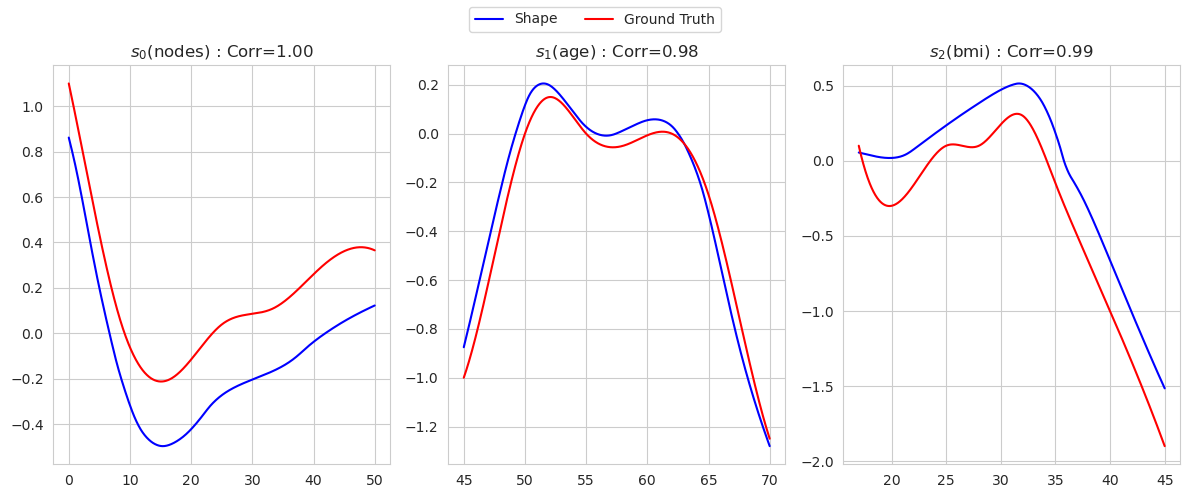

In [10]:
fig_risk

## 4. Univariate Survival

Now we switch from a regression task to a survival task. We always apply administrative censoring at a fixed time $C=10.0$. 

1. $T = X$ 
2. $T = exp(X)$

In [3]:
from survshares.metrics import negative_pll
surv_params = {
    "function_set": [add2, sub2, mul2, div2],
    "arities": {2: [add2, sub2, mul2, div2]},
    "init_depth": (2, 6),
    "init_method": "half and half",
    "n_features": 10,
    "const_range": (-1.0, 1.0),
    "metric": negative_pll,
    "p_point_replace": 0.05,
    "parsimony_coefficient": 0.1,
    "optim_dict": {
        "alg": "adam",
        "lr": 1e-2,  # tuned automatically
        "max_n_epochs": 1000,
        "tol": 1e-3,
        "task": "survival",
        "device": "cpu",
        "batch_size": 1000,
        "shape_class": ShapeNN,
        "constructor_dict": {
            "n_hidden_layers": 5,
            "width": 10,
            "activation_name": "ELU",
        },
        "num_workers_dataloader": 0,
        "seed": 42,
        "checkpoint_folder": "results/checkpoints/test",
        "keep_models": False,
        "enable_progress_bar": False,
    },
    "random_state": check_random_state(415),
}

In [36]:
test_share = [shape1, 0]
C = 1.0
X_train, X_test = np.random.rand(1000, 1), np.random.rand(1000, 1)
T_train, T_test = X_train[:,0], X_test[:,0]
E_train, E_test = (T_train <= C).astype(int), (T_test <= C).astype(int)
T_train, T_test = np.minimum(T_train, C), np.minimum(T_test, C)

gp = _Program(program=test_share, **surv_params)
gp.raw_fitness(torch.Tensor(X_train), torch.Tensor(T_train), torch.tensor(E_train))
y_pred = gp.execute(torch.Tensor(X_test))


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(X0)


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/results/checkpoints/test/unknown exists and is not empty.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(X0)
shape(X0) | raw_fitness: 2.3270020484924316


Predicting: |          | 0/? [00:00<?, ?it/s]

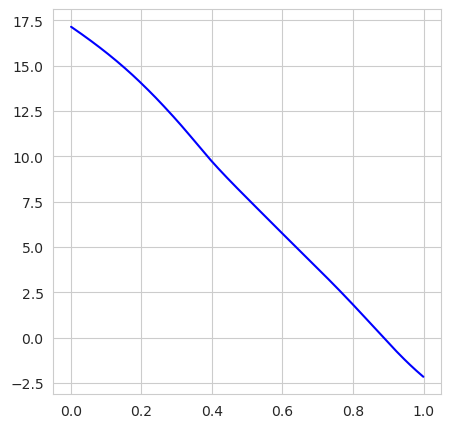

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
idx = np.argsort(X_test[:, 0])
ax.plot(X_test[idx], y_pred[idx], label='Predicted', color='blue')


In [38]:
from lifelines.utils import concordance_index

concordance_index(T_test, -y_pred, E_test)

np.float64(1.0)

In [47]:
from survshares.plot import survival_probability_calibration
from sklearn.base import BaseEstimator, RegressorMixin
from pycox.models.cox import _CoxPHBase
import torchtuples as tt 
class SymRegPH(BaseEstimator, RegressorMixin, _CoxPHBase):
    """
    Wrapper for gplearn's SymbolicRegressor to use with pycox supporting functions
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X, *args, **kwargs):
        if isinstance(X, tt.TupleTree):
            X = X[0]
        return self.model.execute(torch.Tensor(X))
    
esr_wrapped = SymRegPH(gp)
esr_wrapped.compute_baseline_hazards(X_train, (T_train, E_train))
surv_pred = esr_wrapped.predict_surv_df(X_test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
from survshares.datasets import Metabric 
from sklearn.model_selection import train_test_split
dataset = Metabric()
X, T, E = dataset.load()
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(X, T, E, test_size=0.2, random_state=42)
n_features = X.shape[1]
share_test = [add2] * (n_features-1) + [elem for i in range(n_features) for elem in [shape1, i]]
gp = _Program(program=share_test, **surv_params)
gp.raw_fitness(torch.Tensor(X_train), torch.Tensor(T_train), torch.tensor(E_train))
y_pred = gp.execute(torch.Tensor(X_test))
concordance_index(T_test, -y_pred, E_test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(add(add(add(add(add(add(add(shape(X0), shape(X1)), shape(X2)), shape(X3)), shape(X4)), shape(X5)), shape(X6)), shape(X7)), shape(X8))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/results/checkpoints/test/unknown exists and is not empty.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(add(add(add(add(add(add(add(shape(X0), shape(X1)), shape(X2)), shape(X3)), shape(X4)), shape(X5)), shape(X6)), shape(X7)), shape(X8))
add(add(add(add(add(add(add(add(shape(X0), shape(X1)), shape(X2)), shape(X3)), shape(X4)), shape(X5)), shape(X6)), shape(X7)), shape(X8)) | raw_fitness: 5.07103967666626


Predicting: |          | 0/? [00:00<?, ?it/s]

np.float64(0.6256143512450852)

{0: (np.float32(5.1587944), np.float32(14.443632)), 1: (np.float32(4.8606453), np.float32(9.932116)), 2: (np.float32(6.3729486), np.float32(14.6439)), 3: (np.float32(5.1010933), np.float32(7.6588626)), 4: (np.float32(0.0), np.float32(1.0)), 5: (np.float32(0.0), np.float32(1.0)), 6: (np.float32(0.0), np.float32(1.0)), 7: (np.float32(0.0), np.float32(1.0)), 8: (np.float32(21.93), np.float32(96.29))}


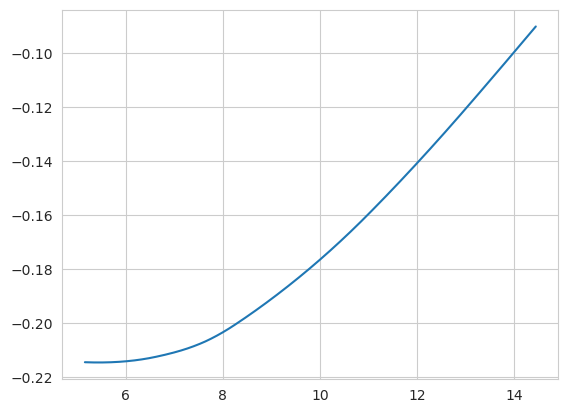

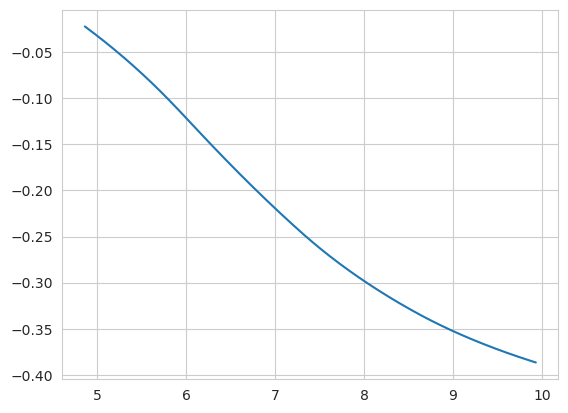

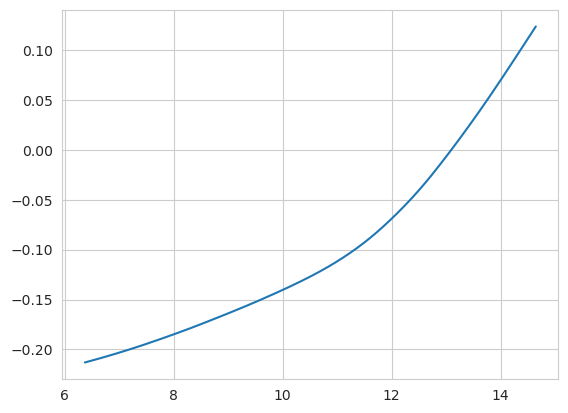

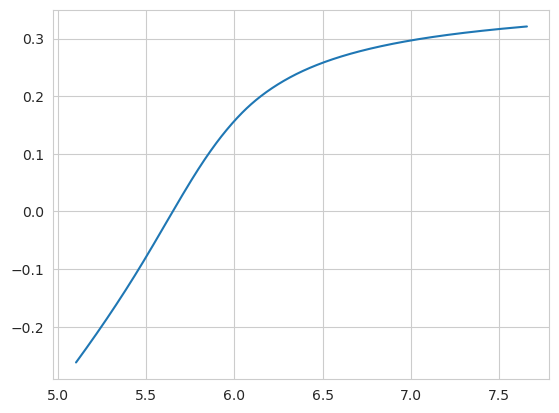

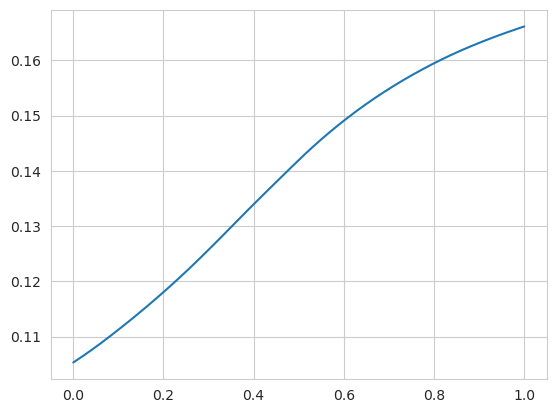

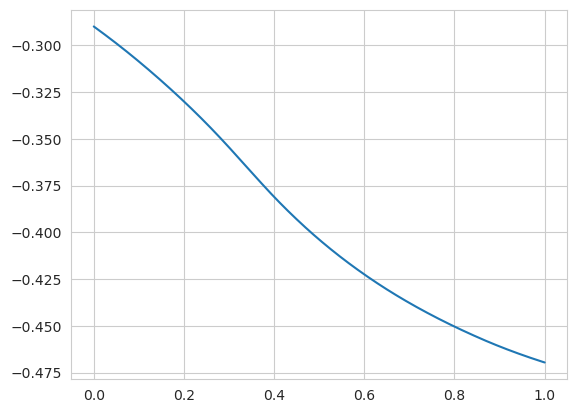

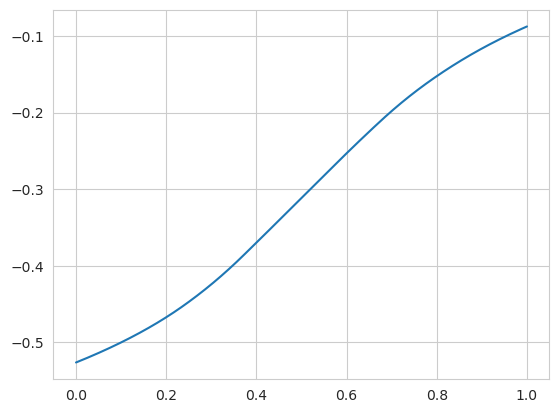

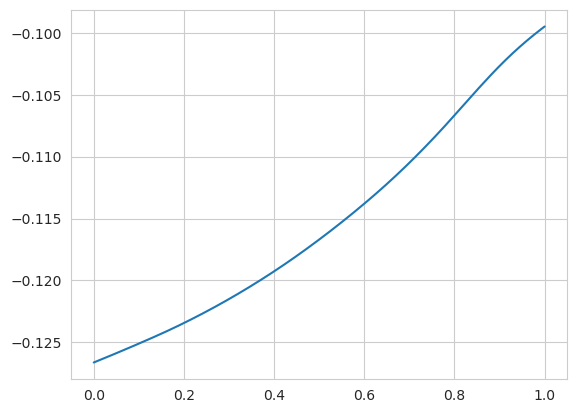

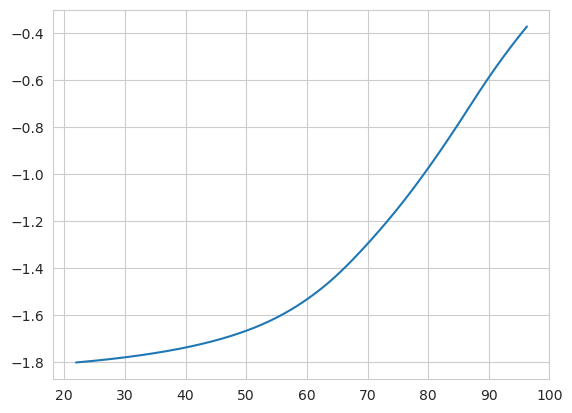

In [83]:
gp.plot_shape_functions({i: (np.min(X[:,i]), np.max(X[:,i])) for i in range(n_features)}, {})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

ICI =  0.09384828149065819
E50 =  0.08258411964256585


<string>:34: RuntimeWarning: divide by zero encountered in log
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/lifelines/fitters/mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 351 mortality'}, xlabel='Predicted probability of \nt ≤ 351 mortality', ylabel='Observed probability of \nt ≤ 351 mortality'>,
 np.float64(0.09384828149065819),
 np.float64(0.08258411964256585))

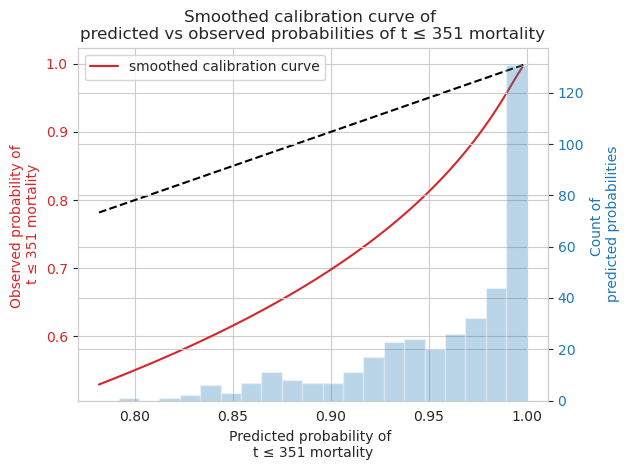

In [84]:
esr_wrapped = SymRegPH(gp)
esr_wrapped.compute_baseline_hazards(X_train, (T_train, E_train))
surv_pred = esr_wrapped.predict_surv_df(X_test)

survival_probability_calibration(surv_pred, T_test+0.01, E_test, t0=surv_pred.index[-1])

<lifelines.CoxPHFitter: fitted with 1904 total observations, 801 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1904
number of events observed = 1103
   partial log-likelihood = -7382.63
         time fit was run = 2025-05-20 14:10:25 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
x0         0.05      1.06      0.04           -0.03            0.14                0.97                1.15
x1        -0.07      0.93      0.03           -0.14           -0.01                0.87                0.99
x2         0.09      1.09      0.02            0.04            0.13                1.04                1.14
x3         0.32      1.38      0.09            0.14            0.50                1.15                1.65
x4         0.15      1.16      0.07            0.01            0.29                1.01                1.33
x5        -0.18      0.83      0.06           -0.31           -0.06                0.74                0.94
x6         0.78      2.17      0.10            0.58            0.97                1.79                2.65
x7         0.07      1.08      0.10           -0.13            0.28                0.88                1.32
x8         0.05      1.05      0.00            0.04            0.05                1.04                1.05

           cmp to     z      p  -log2(p)
covariate                               
x0           0.00  1.29   0.20      2.35
x1           0.00 -2.16   0.03      5.03
x2           0.00  3.82 <0.005     12.86
x3           0.00  3.43 <0.005     10.71
x4           0.00  2.13   0.03      4.92
x5           0.00 -2.89 <0.005      8.04
x6           0.00  7.72 <0.005     46.28
x7           0.00  0.70   0.49      1.04
x8           0.00 14.81 <0.005    162.45
---
Concordance = 0.64
Partial AIC = 14783.27
log-likelihood ratio test = 312.67 on 9 df
-log2(p) of ll-ratio test = 203.54

C-index: 0.6391503770136181
IBS: 0.15634149178879092
ICI =  0.10677235497988785
E50 =  0.11947282063552811


<string>:34: RuntimeWarning: divide by zero encountered in log
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/lifelines/fitters/mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 351 mortality'}, xlabel='Predicted probability of \nt ≤ 351 mortality', ylabel='Observed probability of \nt ≤ 351 mortality'>,
 np.float64(0.10677235497988785),
 np.float64(0.11947282063552811))

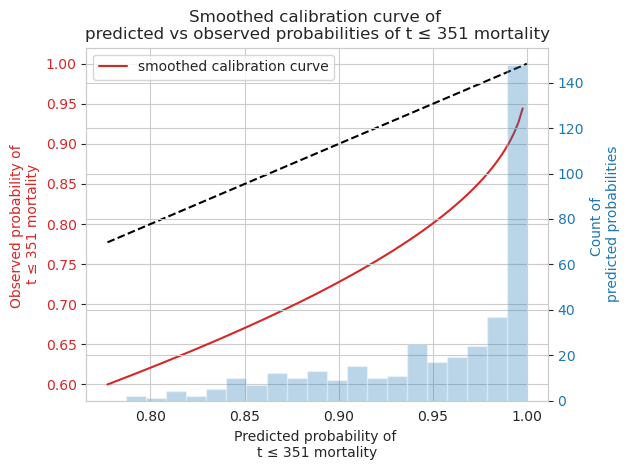

In [91]:
from lifelines import CoxPHFitter
from sksurv.util import Surv
from sksurv.metrics import integrated_brier_score

X_df = pd.DataFrame(X, columns=dataset.features).assign(time=T, event=E)
cph = CoxPHFitter()
cph.fit(X_df, duration_col="time", event_col="event")
cph.print_summary()

# Double check the concordance
from lifelines.utils import concordance_index

c_index = concordance_index(T, -cph.predict_partial_hazard(X), E)
y, t = Surv.from_arrays(E, T), np.unique(T).astype(float)[1:-1]
ibs = integrated_brier_score(y, y, cph.predict_survival_function(X, times=t).T, t)
print(f"C-index: {c_index}")
print(f"IBS: {ibs}")    

class SymRegPH(BaseEstimator, RegressorMixin, _CoxPHBase):
    """
    Wrapper for gplearn's SymbolicRegressor to use with pycox supporting functions
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X, *args, **kwargs):
        if isinstance(X, tt.TupleTree):
            X = X[0]
        return self.model.predict_partial_hazard(X).to_numpy()
    
esr_wrapped = SymRegPH(cph)
esr_wrapped.compute_baseline_hazards(X_train, (T_train, E_train))
surv_pred = esr_wrapped.predict_surv_df(X_test)
survival_probability_calibration(surv_pred, T_test+0.01, E_test, t0=surv_pred.index[-1])